# Initial feature selection - summary

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from matplotlib.axes import Axes

In [2]:
sns.set_style('whitegrid')

In [3]:
CONCEPT_LENGTH = 3000
SWITCH_LENGTH = 300
DRIFTS = [3000, 6000, 9000, 12000, 15000, 18000]

In [4]:
def legend_without_duplicate_labels(ax: Axes):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

### Load data

In [5]:
import ast

In [6]:
adwin_result_path = '../data/interim/2024_04_11_artificial_data/adwin_results.csv'
adwin_result = pd.read_csv(adwin_result_path, index_col=0)
adwin_result['drifts'] = adwin_result['drifts'].apply(lambda x: ast.literal_eval(x))


### Functions

In [7]:
def metrics(truth, detected):
    if len(detected) == 0:
        return 0, 0

    true_positive = 0
    false_positive = 0  

    i_truth = 0
    i_detected = 0
    n_detected_in_interval = 0

    # check conditions over true data drifts, look forward!
    while i_truth < len(truth) and i_detected < len(detected):
        # handle the initial case
        if i_truth == 0 and detected[i_detected] < truth[0]:
            false_positive += 1
            i_detected += 1
        # handle the normal case
        elif i_truth + 1 < len(truth):
            # there is a drift in the current interval
            if detected[i_detected] < truth[i_truth + 1]:
                n_detected_in_interval += 1
                if n_detected_in_interval == 1:
                    true_positive += 1
                else:
                    false_positive += 1
                i_detected += 1
            # drift is in the next interval
            else:
                # if any drift is not detected, delay is equal to the concept length
                i_truth += 1
                n_detected_in_interval = 0
        # handle the case when the current true data drift is the last true
        # that means the end of the time series
        else:
            if detected[i_detected] > truth[i_truth]:
                n_detected_in_interval += 1
                if n_detected_in_interval == 1:
                    true_positive += 1
                else:
                    false_positive += 1
                i_detected += 1
            elif n_detected_in_interval == 0:
                i_truth += 1
    
    if len(detected) == 0:
        fdr = 0
    else:
        fdr = false_positive / len(detected)

        tpr = true_positive / len(truth)
    return fdr, tpr

In [8]:
metrics = pd.DataFrame(adwin_result['drifts'].apply(lambda x: metrics(DRIFTS, x)).tolist())
metrics.columns = ['fdr', 'tpr']

In [9]:
adwin_result['fdr'] = metrics['fdr'].tolist()
adwin_result['tpr'] = metrics['tpr'].tolist()

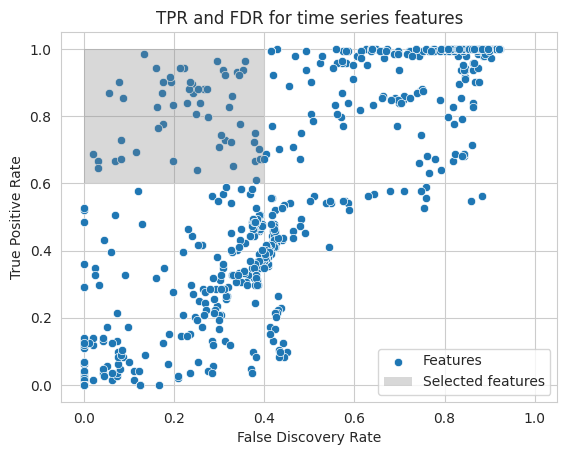

In [10]:
adwin_results_grouped = adwin_result.groupby('feature')[['tpr', 'fdr']].mean().reset_index()
sns.scatterplot(data=adwin_results_grouped, x='fdr', y='tpr', label='Features')
plt.gca().add_patch(Rectangle((0, 0.6), 0.4, 0.4, color="grey", alpha=0.3, linewidth=0, label='Selected features'))
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.title('TPR and FDR for time series features')
plt.xlabel('False Discovery Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

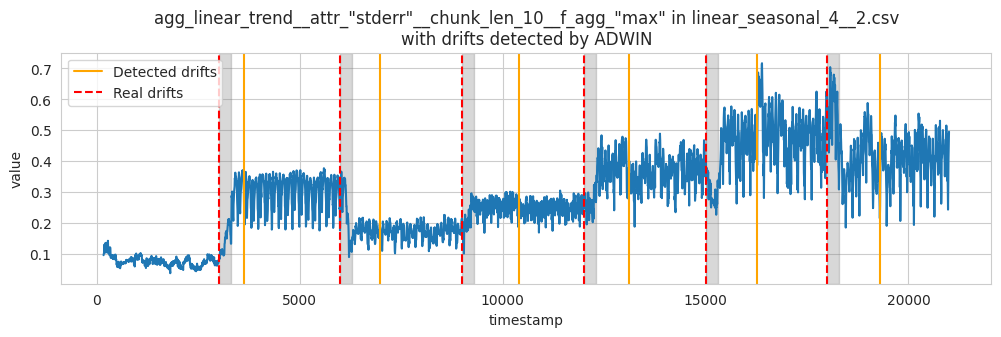

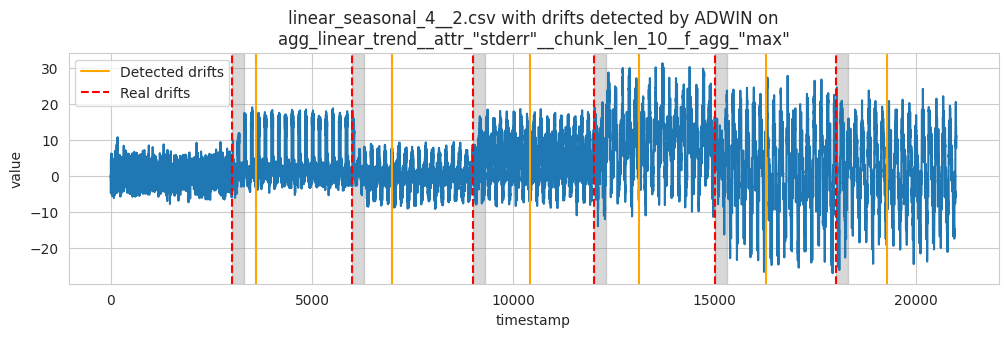

In [11]:
file = 'linear_seasonal_4__2.csv'
feature_selected = 'agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"'
detected = adwin_result[(adwin_result.ts == file) & (adwin_result.feature == feature_selected)]['drifts'].iloc[0]
features = pd.read_csv(f'../data/interim/2024_04_11_artificial_data/features/{file}', index_col=0)
features = features.loc[:, [f'value__{feature_selected}']]
features = features.reset_index()
features.columns = ['timestamp', 'value']

plt.figure(figsize=(12, 3))
sns.lineplot(data=features, x='timestamp', y='value')
for d in detected:
    plt.axvline(x=d, c='orange', label='Detected drifts')
for d in DRIFTS:
    plt.axvline(x=d, c='red', linestyle='--', label='Real drifts')
    plt.axvspan(d, d + SWITCH_LENGTH, color='grey', alpha=0.3)
plt.title(f"{feature_selected} in {file}\nwith drifts detected by ADWIN")
legend_without_duplicate_labels(plt.gca())
plt.show()

original = pd.read_csv(f'../data/raw/2024_04_11_artificial_data/{file}', index_col=0)
plt.figure(figsize=(12, 3))
sns.lineplot(data=original, x='timestamp', y='value')
for d in detected:
    plt.axvline(x=d, c='orange', label='Detected drifts')
for d in DRIFTS:
    plt.axvline(x=d, c='red', linestyle='--', label='Real drifts')
    plt.axvspan(d, d + SWITCH_LENGTH, color='grey', alpha=0.3)
plt.title(f"{file} with drifts detected by ADWIN on\n{feature_selected}")
legend_without_duplicate_labels(plt.gca())
plt.show()